# Classification of bird sound files

<div class="alert alert-warning">
<strong>This notebook assume that the conversion of MP3 files into WAV files has been already done.</strong>

If not, please check the other notebook *birds_sound_visualizations.ipynb*
</div>

From literature, we have found several methods to classify sounds depending on the bird species:

- Logistic Regression
- k Nearest Neighbour (kNN) classifier with histogram-based features
- Support Vector Machines (SVM) with time-summarisation features
- Random Forest

We want a supervised classification, according to the litterature for bird sound SVM and KNN, due to their widespread use and ease of interpretation, will be the best method but it is interesting to compare them to other method thanks to an accuracy value.

The strategy here is to first create a dataframe with all the needed features from the bird sound recording that have been previously converted into wav file. Now that we have our labeled database of previously known bird songs, we use it to create a decision procedure that is used to predict the species of a new bird song.  

### Import libraries

In [32]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import svm

### Create Dataframes

In [33]:
df_all = pd.read_csv('AllBirdsv4.csv')

# Create a new column to tell whether it's a blue pipit or not 
# this is our target for the classification
type=[]
for i in range(len(df_all.index)):
    if str(df_all.loc[i,'English_name']) == 'Rose-crested Blue Pipit':
        type.append(1)
    else: 
        type.append(0)
df_all['Type']=type
df_all_show = df_all.groupby('Type')
df_all_show = df_all_show.apply(lambda x: x.sample(frac=0.3))
display(df_all_show)

File ID             English_name Vocalization_type Quality  \
Type                                                                    
0    598    380344  Carries Champagne Pipit              call       B   
     548    237821        Canadian Cootamum              song       C   
     1042   103965        Lesser Birchbeere              call       B   
     639    390542  Carries Champagne Pipit              call       C   
     600    367479  Carries Champagne Pipit        call, song       B   
     1640   383814               Queenscoat              call       B   
     835    137835       Eastern Corn Skeet              call       C   
     720    349815         Darkwing Sparrow              song       A   
     207      6135     Blue-collared Zipper              song       A   
     1656   343361               Queenscoat              song       B   
     1234   135702       Orange Pine Plover              call       B   
     1152   387175       Orange Pine Plover              song       B   
     1084   154791        Lesser Birchbeere              call       E   
     1547   273048                      Qax              song       A   
     730    325716         Darkwing Sparrow              song       A   
     1429   190346                Pinkfinch              call       B   
     1442    54774                Pinkfinch              call       B   
     445    176376        Broad-winged Jojo              call       B   
     349     50595                 Bombadil              song       B   
     1817    26028               Queenscoat              call       C   
     662     27254  Carries Champagne Pipit              call       C   
     1659   336309               Queenscoat              call       B   
     468     17165        Broad-winged Jojo              Song       B   
     1365   107461           Ordinary Snape              call       B   
     716    358971         Darkwing Sparrow              call       A   
     1848    76077       Bent-beak Riffraff              song       A   
     2065   283265      Vermillion Trillian              call       C   
     774    318747       Eastern Corn Skeet              call       A   
     1622   120467               Queenscoat              call       A   
     486     96700        Broad-winged Jojo              call       D   
...            ...                      ...               ...     ...   
1    14     299736  Rose-crested Blue Pipit              call       A   
     111    191515  Rose-crested Blue Pipit              song       B   
     84     339832  Rose-crested Blue Pipit              call       B   
     31     162563  Rose-crested Blue Pipit              song       A   
     68     345561  Rose-crested Blue Pipit              call       B   
     1      406171  Rose-crested Blue Pipit              call       A   
     97     293913  Rose-crested Blue Pipit              call       B   
     176     63086  Rose-crested Blue Pipit              call       C   
     51      12122  Rose-crested Blue Pipit              song       A   
     114    191417  Rose-crested Blue Pipit              call       B   
     144     34861  Rose-crested Blue Pipit              Song       B   
     47      41283  Rose-crested Blue Pipit              call       A   
     18     277989  Rose-crested Blue Pipit              song       A   
     125    162568  Rose-crested Blue Pipit              call       B   
     77     345552  Rose-crested Blue Pipit              song       B   
     22     181907  Rose-crested Blue Pipit              call       A   
     67     345562  Rose-crested Blue Pipit              call       B   
     42     106772  Rose-crested Blue Pipit              call       A   
     133    113144  Rose-crested Blue Pipit              call       B   
     94     305761  Rose-crested Blue Pipit              song       B   
     12     353709  Rose-crested Blue Pipit              call       A   
     165    206618  Rose-crested Blue Pipit              song       C

In [34]:
# Read all sounds files
folder_path = 'all_birds_wav'
files = os.listdir(folder_path)

sounds_all = []
for file_id in df_all_show['File ID']: 
    # Read WAV file
    f = os.path.join(folder_path, "%s.wav" % (file_id))
    rate, data = wavfile.read(f)
    sounds_all.append(data[:500000])

In [35]:
# Read the tests sounds of Kasios
folder_path = 'test_birds_kasios_wav'
files = os.listdir(folder_path)

sounds_test = []
for file in files:
    f = os.path.join(folder_path, file)
    rate, data = wavfile.read(f)
    sounds_test.append(data[:500000])

In [36]:
# Compute 4 parameters for all sounds
mean_all = []
std_all = []
min_all = []
max_all = []

for sound in sounds_all:
    mean_all.append(np.mean(sound))
    std_all.append(np.std(sound))
    min_all.append(np.min(sound))
    max_all.append(np.max(sound))

df_all_show = df_all_show.assign(mean=mean_all, std=std_all, 
                                 min=min_all, max=max_all)

df_all_show.head()

File ID             English_name Vocalization_type Quality  \
Type                                                                    
0    598    380344  Carries Champagne Pipit              call       B   
     548    237821        Canadian Cootamum              song       C   
     1042   103965        Lesser Birchbeere              call       B   
     639    390542  Carries Champagne Pipit              call       C   
     600    367479  Carries Champagne Pipit        call, song       B   

              Time        Date    X    Y  Type      mean          std    min  \
Type                                                                           
0    598     11:00   5/12/2017   91  140     0  0.759806  3564.837692 -30995   
     548     10:00   4/28/2015   24  124     0 -0.275414    81.188745   -829   
     1042  10:30am   6/17/2012   65   57     0 -0.068767  3753.717428 -32332   
     639     17:00  10/22/2017  134   52     0 -0.513514   320.002614  -2136   
     600     11:00    5/2/2017  158   13     0  3.589000  1340.101540 -20269   

             max  
Type              
0    598   32767  
     548     865  
     1042  31834  
     639    2393  
     600   31516

In [37]:
# Compute 4 parameters for test sounds
df_test = pd.read_csv('Test Birds Location.csv')
mean_test = []
std_test = []
min_test = []
max_test = []

for sound in sounds_test:
    mean_test.append(np.mean(sound))
    std_test.append(np.std(sound))
    min_test.append(np.min(sound))
    max_test.append(np.max(sound))

df_test = df_test.assign(mean=mean_test, std=std_test, 
                         min=min_test, max=max_test)

df_test = df_test.drop(columns=['ID'])

df_test.head()

,X,Y,mean,std,min,max
0,140,119,-0.072540,794.113556,-6766,9935
1,63,153,-0.199194,877.144848,-12501,12258
2,70,136,-0.405632,957.414030,-11614,14137
3,78,150,-0.073872,685.782020,-8716,8549
4,60,90,-0.306266,1549.637434,-12257,11579


### k Nearest Neighbour (k-NN) classifier

#### 1) Training Model

In [38]:
X_sample = df_all_show.drop(columns=['Quality', 'English_name', 
                                     'Vocalization_type', 'Time', 'Date', 
                                     'File ID', 'Type'])
X_sample["Y"] = X_sample["Y"].map(lambda y: y.replace("?",""))
X_sample['Y'] = X_sample['Y'].astype(float)

X = []

y = list(df_all_show["Type"])

for row in X_sample.iterrows():
    index, data = row
    X.append(data.tolist())

In [39]:
# k-NN training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [40]:
# Accuracy of the model
accuracy = clf.score(X_test, y_test)
print("Accuracy of the model: %s" % accuracy)

# Confusion matrix
y_predict= clf.predict(X_test)
print("Confusion matrix: \n%s" % confusion_matrix(y_test, y_predict))

Accuracy of the model: 0.896
Confusion matrix: 
[[112   2]
 [ 11   0]]


#### 2) Predicting on Kasios test sounds 

In [41]:
X_kasios = []

for row in df_test.iterrows():
    index, data = row
    X_kasios.append(data.tolist())

In [42]:
kasios_prediction = clf.predict(X_kasios)
for i in range(len(kasios_prediction)):
    print("Sound test %s - Prediction : %s" % (i+1, kasios_prediction[i]))

Sound test 1 - Prediction : 0
Sound test 2 - Prediction : 0
Sound test 3 - Prediction : 0
Sound test 4 - Prediction : 0
Sound test 5 - Prediction : 0
Sound test 6 - Prediction : 0
Sound test 7 - Prediction : 0
Sound test 8 - Prediction : 0
Sound test 9 - Prediction : 0
Sound test 10 - Prediction : 0
Sound test 11 - Prediction : 0
Sound test 12 - Prediction : 1
Sound test 13 - Prediction : 0
Sound test 14 - Prediction : 0
Sound test 15 - Prediction : 0


<div class='alert alert-info'>
According to our <b>k-NN classifier</b>, only the 12th Kasios test sound <b>seems</b> to be Blue Pipit one.
<div>  

### Support Vector Machine (SVM) classifier

#### 1) Training Model

In [23]:
x_list = np.linspace(2**-5, 2**5, 30)
accuracy_C = []
for x in x_list:
    model = svm.SVC(kernel='linear', C=x)
    model.fit(X_train, y_train)
    accuracy_C.append(model.score(X_test, y_test))
x = 0

# select the C with max accuracy
max_index = accuracy_C.index(max(accuracy_C))
C_chosed = x_list[max_index]

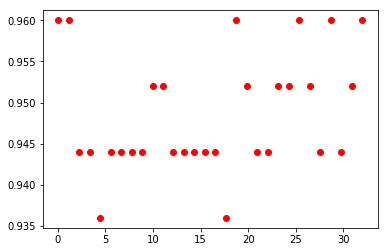

In [14]:
plt.plot(x_list, accuracy_C, 'ro')
plt.show()

In [15]:
# we do the same thing for gamma

accuracy_gamma = []
for x in x_list:
    model = svm.SVC(kernel='linear', C=C_chosed, gamma=x)
    model.fit(X_train, y_train)
    accuracy_gamma.append(model.score(X_test, y_test))

# to find the C with the max accuracy
max_index = accuracy_gamma.index(max(accuracy_gamma))
gamma_chosed = x_list[max_index]  # the C that we will choose

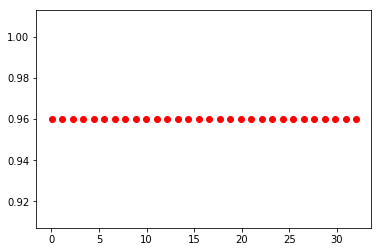

In [16]:
plt.plot(x_list, accuracy_gamma, 'ro')
plt.show()

In [18]:
# We can now define our SVM model
model = svm.SVC(kernel='linear', C=C_chosed, gamma=gamma_chosed)
model.fit(X_train, y_train)

SVC(C=0.03125, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.03125, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [19]:
# Accuracy of the model
accuracy = model.score(X_test, y_test)
print("Accuracy of the model: %s" % accuracy)

# Confusion matrix
y_predict = model.predict(X_test)
print("Confusion matrix: \n%s" % confusion_matrix(y_test, y_predict))

Accuracy of the model: 0.96
Confusion matrix: 
[[118   1]
 [  4   2]]


#### 2) Predicting on Kasios test sounds 

In [22]:
kasios_prediction = model.predict(X_kasios)
for i in range(len(kasios_prediction)):
    print("Sound test %s - Prediction : %s" % (i+1, kasios_prediction[i]))

Sound test 1 - Prediction : 0
Sound test 2 - Prediction : 0
Sound test 3 - Prediction : 0
Sound test 4 - Prediction : 0
Sound test 5 - Prediction : 0
Sound test 6 - Prediction : 0
Sound test 7 - Prediction : 0
Sound test 8 - Prediction : 0
Sound test 9 - Prediction : 0
Sound test 10 - Prediction : 0
Sound test 11 - Prediction : 1
Sound test 12 - Prediction : 0
Sound test 13 - Prediction : 0
Sound test 14 - Prediction : 0
Sound test 15 - Prediction : 0


<div class='alert alert-info'>
According to our <b>SVM classifier</b>, only the 11th test sound from Kasios <b>seems</b> to be a Rose crested Blue Pipit.
<div>  